<a href="https://colab.research.google.com/github/chain-veerender/100-Days-Of-ML-Code/blob/master/Recommendation_customerbeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DDDD.xlsx to DDDD.xlsx


In [6]:
import pandas as pd
data = pd.read_excel('DDDD.xlsx')
data.head()

,SalesDate,SalesValue,SalesAmount,Customer,SalesTransactionID,SalesItem
0,2018-09-28,8280.0,10,0,0,0
1,2018-09-28,7452.0,10,0,0,0
2,2019-04-23,21114.0,30,0,1,0
3,2019-04-23,7038.0,10,0,1,1
4,2019-04-23,7000.0,2,0,1,2


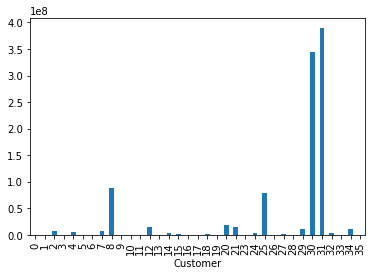

In [10]:
#data_agg=data.groupby('Customer').agg(['SalesValue'])
import matplotlib.pyplot as plt
data_agg = data.groupby(['Customer'])['SalesValue'].sum()
data_agg.head()
data_agg.plot(x='Customer', y='SalesValue',kind="bar")
plt.show()

**Sparsity**

In [11]:
DataPrep = data[['SalesItem', 'SalesAmount', 'Customer']] #we will only use SalesItem, SalesAmount and Customer for our recommending purpose
DataPrep.head()

,SalesItem,SalesAmount,Customer
0,0,10,0
1,0,10,0
2,0,30,0
3,1,10,0
4,2,2,0


In [12]:
DataGrouped = DataPrep.groupby(['Customer', 'SalesItem']).sum().reset_index() # Group together
DataGrouped.head()

,Customer,SalesItem,SalesAmount
0,0,0,281
1,0,1,158
2,0,2,13
3,0,768,1
4,1,3,2


In [13]:
#make sure that no values <=0 exist
DataGroupedZero = DataGrouped.query('SalesAmount <= 0')
DataGroupedZero.head()

,Customer,SalesItem,SalesAmount


In [14]:
import numpy as np
customers = list(np.sort(DataGrouped.Customer.unique())) # why 36 unique customers in a list and not 35? Index starts at 0!
products = list(DataGrouped.SalesItem.unique()) # Get our unique 3725 unique products that were purchased
quantity = list(DataGrouped.SalesAmount) # All of our purchases
#list function is a list of values. So customers now stores 36 unique customers.

In [15]:
from pandas import DataFrame
DfCustomerUnique = DataFrame(customers,columns=['Customer'])
DfCustomerUnique.head()

,Customer
0,0
1,1
2,2
3,3
4,4


In [16]:
from scipy import sparse
from pandas.api.types import CategoricalDtype

rows = DataGrouped.Customer.astype(CategoricalDtype(categories=customers)).cat.codes # We have got 36 unique customers, which make up 13837 data rows (index)

# Get the associated row indices
cols = DataGrouped.SalesItem.astype(CategoricalDtype(categories= products)).cat.codes # We have got unique 3725 SalesItems, making up 13837 data rows (index)

# Get the associated column indices
#Compressed Sparse Row matrix
PurchaseSparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products))) #len of customers=35, len of products=3725
#csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

PurchaseSparse
#a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products

<35x3725 sparse matrix of type '<class 'numpy.longlong'>'
	with 13837 stored elements in Compressed Sparse Row format>

In [17]:
#We have 35 customers with 3725 items. For these user/item interactions, 13837 of these items had a purchase. 
#In terms of sparsity of the matrix, that makes:
MatrixSize = PurchaseSparse.shape[0]*PurchaseSparse.shape[1] # 130375 possible interactions in the matrix (35 unique customers * 3725 unique SalesItems=130375)
PurchaseAmount = len(PurchaseSparse.nonzero()[0]) # 13837 SalesItems interacted with; 
sparsity = 100*(1 - (PurchaseAmount/MatrixSize))
sparsity

89.38676893576223

Building Recommendation Engine 

In [18]:
#for every dataset we will add a 1 as purchased. That means, that this customer has purchased this item, no matter how many. We use this binary data for our recommending. Another approach would be to use the SalesAmount and 
#normalize it, in case you want to treat the Amount of SalesItems purchased as a kind of taste factor, meaning that someone who bought SalesItem x 100 times, while another Customer bought that same SalesItem x only 5 times does 
#not like it as much. I believe, that very often in Sales a binary approach makes more sense, but of course that depends on the data.
def create_DataBinary(DataGrouped):
  # DataPrep must be DataGrouped?!
    DataBinary = DataPrep.copy()
    DataBinary['PurchasedYes'] = 1 
    return DataBinary

DataBinary = create_DataBinary(DataGrouped)
DataBinary.head()

,SalesItem,SalesAmount,Customer,PurchasedYes
0,0,10,0,1
1,0,10,0,1
2,0,30,0,1
3,1,10,0,1
4,2,2,0,1


In [19]:
data2=DataBinary.drop(['SalesAmount'], axis=1)
data2.head()

,SalesItem,Customer,PurchasedYes
0,0,0,1
1,0,0,1
2,0,0,1
3,1,0,1
4,2,0,1


In [20]:
#for better convenience we add I for Item for every SalesItem. Otherwise we would only have customer and SalesItem Numbers, which can be a little bit puzzling.
data2['SalesItem'] = 'I' + data2['SalesItem'].astype(str)

In [21]:
#DfMatrix = pd.pivot_table(data,index=["Customer"], columns='SalesItem')
DfMatrix = pd.pivot_table(data2, values='PurchasedYes', index='Customer', columns='SalesItem')
DfMatrix.head()

SalesItem,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
display(DfMatrix)

SalesItem,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [25]:
#since we are only using 1 and 0, we do not need to think about normalization. But talk is cheap, let`s check to see that even if we would normalize, the result is the same, of course:
DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been purchased yet.
DfMatrixNorm3 = (DfMatrix-DfMatrix.min())/(DfMatrix.max()-DfMatrix.min())
DfMatrixNorm3.head()
#the proof is in the pudding. But we will come back to normalization later on again, when we will take real Sales Amount into consideration for recommending as well.

SalesItem,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#we need to bring our pivot table into the desired format, via reset_index and rename_axis. 
DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 
DfResetted.head()
#Now each row represents one customer`s buying behaviour: 1 means the customer has purchased, NaN the customer has not yet purchased it

,Customer,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
DfMatrix.shape

(35, 3725)

In [28]:
df=DfResetted #now working: because Customer must be nvarchar! If customer is int, then failure during CustItemSimilarity!

In [29]:
#we need to replace the NaN values with a 0, because our function will not work on NaN values.
#Please note, that we are only checking if a specific customer bought a specific item, yes or no. That is called binary. If customer bought a specific item, that means 1. If not, then 0. Because of this binary problem there is 
#no use in using any further scaling techniques.
df=df.fillna(0)
df.head()

,Customer,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Creating a dataframe which only includes Sales Items. Customer is indexed instead.
DfSalesItem = df.drop('Customer', 1) 
DfSalesItem.head()

,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Calculate the Item based recommendation
import numpy as np
# We will normalize dataframe now, due to ..
#I believe we do not need to normalize, but let us compare..
#vectorized
DfSalesItemNorm = DfSalesItem / np.sqrt(np.square(DfSalesItem).sum(axis=0)) 
DfSalesItemNorm.head()

,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,0.333333,0.301511,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.408248,0.288675,0.5,0.0,0.0,0.0,0.0,0.333333,0.288675,0.0,0.0,0.0,0.27735,0.0,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.353553,0.353553,0.301511,0.0,0.447214,0.353553,0.0,0.408248,0.447214,0.0,0.377964,0.447214,0.0,0.267261,0.408248,0.408248,0.0,...,0.377964,0.000000,0.333333,0.0,0.377964,0.0,0.333333,0.316228,0.408248,0.353553,0.0,0.353553,0.316228,0.5,0.0,0.0,0.0,0.447214,0.288675,0.000000,0.0,0.447214,0.447214,0.0,0.377964,0.0,0.0,0.333333,0.0,0.288675,0.0,0.447214,0.447214,0.0,0.377964,0.0,0.0,0.353553,0.408248,0.0
3,0.000000,0.000000,0.408248,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.27735,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.267261,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.288675,0.0,0.0,0.0,0.0,0.0,0.000000,0.288675,0.0,0.0,0.0,0.27735,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.353553,0.301511,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.267261,0.000000,0.000000,0.0,...,0.000000,0.408248,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.288675,0.377964,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.288675,0.0,0.447214,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [32]:
# Calculating with Vectors to compute Cosine Similarities
ItemItemSim = DfSalesItemNorm.transpose().dot(DfSalesItemNorm) 
ItemItemSim.head()

,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
I0,1.000000,0.703526,0.136083,0.192450,0.333333,0.384900,0.235702,0.333333,0.384900,0.222222,0.192450,0.272166,0.235702,0.235702,0.184900,0.333333,0.272166,0.272166,0.298142,0.272166,0.298142,0.298142,0.298142,0.235702,0.235702,0.201008,0.272166,0.298142,0.235702,0.235702,0.272166,0.298142,0.298142,0.251976,0.298142,0.272166,0.178174,0.272166,0.272166,0.298142,...,0.251976,0.272166,0.222222,0.251976,0.251976,0.251976,0.222222,0.210819,0.136083,0.235702,0.384900,0.235702,0.210819,0.333333,0.384900,0.235702,0.384900,0.298142,0.192450,0.251976,0.384900,0.149071,0.149071,0.235702,0.251976,0.166667,0.298142,0.222222,0.333333,0.192450,0.333333,0.298142,0.298142,0.192450,0.251976,0.384900,0.384900,0.235702,0.272166,0.384900
I1,0.703526,1.000000,0.123091,0.174078,0.150756,0.174078,0.000000,0.301511,0.174078,0.201008,0.174078,0.123091,0.000000,0.000000,0.167248,0.150756,0.246183,0.246183,0.269680,0.123091,0.134840,0.134840,0.134840,0.213201,0.106600,0.090909,0.123091,0.134840,0.213201,0.213201,0.246183,0.134840,0.134840,0.227921,0.134840,0.246183,0.161165,0.246183,0.246183,0.269680,...,0.227921,0.123091,0.201008,0.227921,0.227921,0.113961,0.201008,0.190693,0.123091,0.106600,0.174078,0.106600,0.190693,0.150756,0.174078,0.213201,0.174078,0.134840,0.174078,0.113961,0.174078,0.134840,0.134840,0.213201,0.227921,0.150756,0.134840,0.201008,0.301511,0.174078,0.301511,0.134840,0.134840,0.174078,0.227921,0.174078,0.174078,0.213201,0.246183,0.174078
I10,0.136083,0.123091,1.000000,0.589256,0.408248,0.235702,0.000000,0.204124,0.235702,0.680414,0.589256,0.333333,0.000000,0.000000,0.679366,0.408248,0.500000,0.500000,0.365148,0.666667,0.547723,0.547723,0.547723,0.577350,0.577350,0.615457,0.666667,0.547723,0.577350,0.288675,0.500000,0.547723,0.547723,0.617213,0.547723,0.500000,0.654654,0.500000,0.500000,0.365148,...,0.462910,0.500000,0.544331,0.462910,0.462910,0.617213,0.680414,0.645497,0.833333,0.721688,0.235702,0.721688,0.645497,0.408248,0.235702,0.288675,0.235702,0.547723,0.589256,0.462910,0.235702,0.547723,0.547723,0.288675,0.617213,0.612372,0.365148,0.680414,0.204124,0.589256,0.204124,0.365148,0.547723,0.235702,0.462910,0.235702,0.235702,0.577350,0.500000,0.235702
I100,0.192450,0.174078,0.589256,1.000000,0.577350,0.500000,0.408248,0.577350,0.500000,0.866025,0.833333,0.589256,0.408248,0.408248,0.960769,0.577350,0.707107,0.707107,0.645497,0.707107,0.645497,0.645497,0.645497,0.714435,0.816497,0.957427,0.707107,0.645497,0.714435,0.408248,0.707107,0.645497,0.645497,0.763763,0.645497,0.707107,0.925820,0.707107,0.707107,0.645497,...,0.654654,0.707107,0.866025,0.654654,0.654654,0.763763,0.769800,0.912871,0.707107,0.816497,0.500000,0.816497,0.821584,0.577350,0.500000,0.408248,0.500000,0.645497,1.000000,0.763763,0.500000,0.645497,0.645497,0.408248,0.763763,0.577350,0.516398,0.866025,0.577350,0.916667,0.577350,0.645497,0.645497,0.500000,0.763763,0.500000,0.500000,0.714435,0.707107,0.500000
I1000,0.333333,0.150756,0.408248,0.577350,1.000000,0.866025,0.707107,0.750000,0.866025,0.666667,0.577350,0.612372,0.707107,0.707107,0.554700,0.750000,0.612372,0.612372,0.670820,0.816497,0.670820,0.670820,0.670820,0.707107,0.707107,0.603023,0.612372,0.894427,0.707107,0.707107,0.816497,0.894427,0.670820,0.755929,0.894427,0.612372,0.534522,0.816497,0.816497,0.670820,...,0.755929,0.612372,0.666667,0.566947,0.755929,0.566947,0.666667,0.632456,0.612372,0.707107,0.866025,0.707107,0.632456,1.000000,0.866025,0.707107,0.866025,0.894427,0.577350,0.566947,0.866025,0.670820,0.670820,0.707107,0.755929,0.500000,0.670820,0.666667,0.750000,0.577350,0.750000,0.894427,0

In [33]:
#Another approach to the above would be using corr fct
#Where is the difference?
SalesItemCorrelation = DfSalesItem.corr()
SalesItemCorrelation.head()

,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,I1032,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
I0,1.000000,0.587412,-0.094161,-0.149528,0.199600,0.286896,0.136795,0.199600,0.286896,-0.047009,-0.149528,0.079293,0.136795,0.136795,-0.181680,0.199600,0.079293,0.079293,0.133440,0.079293,0.133440,0.133440,0.133440,-0.008896,-0.008896,-0.116678,0.079293,0.133440,-0.008896,0.136795,0.079293,0.133440,0.133440,0.032686,0.133440,0.079293,-0.213504,0.079293,0.079293,0.133440,...,0.032686,0.079293,-0.047009,0.032686,0.032686,0.032686,-0.047009,-0.082690,-0.094161,-0.008896,0.286896,-0.008896,-0.082690,0.199600,0.286896,0.136795,0.286896,0.133440,-0.149528,0.032686,0.286896,-0.053376,-0.053376,0.136795,0.032686,-0.005871,0.133440,-0.047009,0.199600,-0.149528,0.199600,0.133440,0.133440,0.053376,0.032686,0.286896,0.286896,-0.008896,0.079293,0.286896
I1,0.587412,1.000000,-0.144639,-0.229686,-0.049743,0.012563,-0.166667,0.143701,0.012563,-0.116678,-0.229686,-0.144639,-0.166667,-0.166667,-0.265667,-0.049743,0.018663,0.018663,0.075378,-0.144639,-0.100504,-0.100504,-0.100504,-0.075378,-0.221946,-0.325758,-0.144639,-0.100504,-0.075378,0.098485,0.018663,-0.100504,-0.100504,-0.030773,-0.100504,0.018663,-0.301511,0.018663,0.018663,0.075378,...,-0.030773,-0.144639,-0.116678,-0.030773,-0.030773,-0.184637,-0.116678,-0.155700,-0.144639,-0.221946,0.012563,-0.221946,-0.155700,-0.049743,0.012563,0.098485,0.012563,-0.100504,-0.229686,-0.184637,0.012563,-0.100504,-0.100504,0.098485,-0.030773,-0.049743,-0.100504,-0.116678,0.143701,-0.229686,0.143701,-0.100504,-0.100504,0.012563,-0.030773,0.012563,0.012563,-0.075378,0.018663,0.012563
I10,-0.094161,-0.144639,1.000000,0.470011,0.313164,0.131534,-0.111979,0.074887,0.131534,0.599657,0.470011,0.195402,-0.111979,-0.111979,0.591720,0.313164,0.396552,0.396552,0.247594,0.597701,0.464238,0.464238,0.464238,0.474555,0.474555,0.508569,0.597701,0.464238,0.474555,0.214625,0.396552,0.464238,0.464238,0.530669,0.464238,0.396552,0.557086,0.396552,0.396552,0.247594,...,0.341144,0.396552,0.426202,0.341144,0.341144,0.530669,0.599657,0.551383,0.798851,0.655092,0.131534,0.655092,0.551383,0.313164,0.131534,0.214625,0.131534,0.464238,0.470011,0.341144,0.131534,0.464238,0.464238,0.214625,0.530669,0.551442,0.247594,0.599657,0.074887,0.470011,0.074887,0.247594,0.464238,0.131534,0.341144,0.131534,0.131534,0.474555,0.396552,0.131534
I100,-0.149528,-0.229686,0.470011,1.000000,0.497305,0.423896,0.340825,0.497305,0.423896,0.814531,0.746377,0.470011,0.340825,0.340825,0.939651,0.497305,0.629724,0.629724,0.565194,0.629724,0.565194,0.565194,0.565194,0.610246,0.753592,0.937268,0.629724,0.565194,0.610246,0.340825,0.629724,0.565194,0.565194,0.692219,0.565194,0.629724,0.884652,0.629724,0.629724,0.565194,...,0.541736,0.629724,0.814531,0.541736,0.541736,0.692219,0.676809,0.875595,0.629724,0.753592,0.423896,0.753592,0.742352,0.497305,0.423896,0.340825,0.423896,0.565194,1.000000,0.692219,0.423896,0.565194,0.565194,0.340825,0.692219,0.497305,0.393179,0.814531,0.497305,0.873188,0.497305,0.565194,0.565194,0.423896,0.692219,0.423896,0.423896,0.610246,0.629724,0.423896
I1000,0.199600,-0.049743,0.313164,0.497305,1.000000,0.852386,0.685344,0.717742,0.852386,0.610541,0.497305,0.551442,0.685344,0.685344,0.467293,0.717742,0.551442,0.551442,0.623250,0.789719,0.623250,0.623250,0.623250,0.659912,0.659912,0.530589,0.551442,0.879883,0.659912,0.685344,0.789719,0.879883,0.623250,0.718421,0.879883,0.551442,0.439941,0.789719,0.789719,0.623250,...,0.718421,0.551442,0.610541,0.493915,0.718421,0.493915,0.610541,0.567962,0.551442,0.659912,0.852386,0.659912,0.567962,1.000000,0.852386,0.685344,0.852386,0.879883,0.497305,0.493915,0.852386,0.623250,0.6232

In [34]:
#ItemItemSim.to_excel("ExportItem-Item.xlsx")
# Create a placeholder items for closes neighbours to an item
ItemNeighbours = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,10))
ItemNeighbours.head()

,1,2,3,4,5,6,7,8,9
I0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Create a placeholder items for closes neighbours to an item
#ItemNeighbours = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,10)) 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(ItemItemSim.columns)):
    ItemNeighbours.iloc[i,:9] = ItemItemSim.iloc[0:,i].sort_values(ascending=False)[:9].index
    #we only have 9 items, so we can max recommend 9 items (itself included)

In [36]:
ItemNeighbours.head()

,1,2,3,4,5,6,7,8,9
I0,I0,I2,I1,I769,I1134,I705,I704,I1139,I1138
I1,I1,I768,I759,I758,I754,I757,I749,I750,I753
I10,I10,I1699,I1696,I1674,I2102,I19,I1242,I970,I254
I100,I161,I86,I146,I128,I71,I152,I193,I89,I200
I1000,I747,I962,I1041,I893,I930,I1000,I790,I975,I917


In [37]:
ItemNeighbours.head().iloc[:11,1:9]
#it needs to start at position 1, because position 0 is itself

,2,3,4,5,6,7,8,9
I0,I2,I1,I769,I1134,I705,I704,I1139,I1138
I1,I768,I759,I758,I754,I757,I749,I750,I753
I10,I1699,I1696,I1674,I2102,I19,I1242,I970,I254
I100,I86,I146,I128,I71,I152,I193,I89,I200
I1000,I962,I1041,I893,I930,I1000,I790,I975,I917


In [38]:
ItemNeighbours.to_excel("ExportItem-Item-data_neighbours.xlsx")

In [39]:
#Now we will build a Customer based recommendation, which is build upon the item-item similarity matrix, which we have just calculated above.
# Create a place holder matrix for similarities, and fill in the customer column
CustItemSimilarity = pd.DataFrame(index=df.index,columns=df.columns)
CustItemSimilarity.iloc[:,:1] = df.iloc[:,:1]

In [40]:
CustItemSimilarity.head()

,Customer,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Getting the similarity scores
def getScore(history, similarities):
   return sum(history*similarities)/sum(similarities)

In [42]:
# This takes ages (35 customers * 3725 items)
#We now loop through the rows and columns filling in empty spaces with similarity scores.
#Note that we score items that the customer has already consumed as 0, because there is no point recommending it again.
from timeit import default_timer as timer #to see how long the computation will take
start = timer()


for i in range(0,len(CustItemSimilarity.index)):
    for j in range(1,len(CustItemSimilarity.columns)):
        user = CustItemSimilarity.index[i]
        product = CustItemSimilarity.columns[j]
 
        if df.loc[i][j] == 1:
            CustItemSimilarity.loc[i][j] = 0
        else:
            ItemTop = ItemNeighbours.loc[product][1:9] #
            #do not use order but sort_values in latest pandas
            ItemTopSimilarity = ItemItemSim.loc[product].sort_values(ascending=False)[1:9]
            #here we will use the item dataframe, which we generated during item-item matrix 
            CustomerPurchasings = DfSalesItem.loc[user,ItemTop]
 
            CustItemSimilarity.loc[i][j] = getScore(CustomerPurchasings,ItemTopSimilarity)

end = timer()

print('\nRuntime: %0.2fs' % (end - start))

#if there occurs a strange error  tz=getattr(series.dtype, 'tz', None) .. pandas index.. then this might be if you have used int
# as column headers instead of string



Runtime: 513.62s


In [43]:
CustItemSimilarity.head()

,Customer,I0,I1,I10,I100,I1000,I1001,I1002,I1003,I1004,I1005,I1006,I1007,I1008,I1009,I101,I1010,I1011,I1012,I1013,I1014,I1015,I1016,I1017,I1018,I1019,I102,I1020,I1021,I1022,I1023,I1024,I1025,I1026,I1027,I1028,I1029,I103,I1030,I1031,...,I963,I964,I965,I966,I967,I968,I969,I97,I970,I971,I972,I973,I974,I975,I976,I977,I978,I979,I98,I980,I981,I982,I983,I984,I985,I986,I987,I988,I989,I99,I990,I991,I992,I993,I994,I995,I996,I997,I998,I999
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0.121708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.122838,0,0.121708,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0.114834,0,0,0,0.123409,0,0,0,0.114834,0.242708,0.242708,0,0,0.247053,0,0,0,0,0,0,0,0,0,0,0,0.247053,0,0,0.242708,0,0,0,...,0,0,0,0.743582,0,0.867513,0,0,0,0,0,0,0,0,0,0,0,0,0,0.247861,0,0,0,0,0,0,0,0,0.114834,0,0.114834,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0.128592,0,0,0,0,0,0,0,0,0,0,0,0,0.121845,0,0.24324,0,0,0,0,0,0,0,0.12393,0,0,0,0,0,...,0,0,0,0,0,0,0,0.1213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0.122612,0,0,0,0,0,0,0.365125,0,0.123409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.121767,0.117963,0,0,0,0.117963,0,0,0.117963,0,0,0,0,...,0,0,0,0,0,0,0,0.242599,0,0,0,0,0.12243,0,0,0,0,0.117963,0,0,0,0.11758,0.11758,0,0,0,0,0.365125,0,0,0,0,0.117963,0,0.495722,0,0,0,0,0


In [44]:
#now generate a matrix of customer based recommendations
CustItemRecommend = pd.DataFrame(index=CustItemSimilarity.index, columns=['Customer','1','2','3','4','5','6']) #Top 1,2..6
CustItemRecommend.head()

,Customer,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
CustItemRecommend.iloc[0:,0] = CustItemSimilarity.iloc[:,0]
CustItemRecommend.head()

,Customer,1,2,3,4,5,6
0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#Instead of having the matrix filled with similarity scores we want to see the product names.
for i in range(0,len(CustItemSimilarity.index)):
    CustItemRecommend.iloc[i,1:] = CustItemSimilarity.iloc[i,:].sort_values(ascending=False).iloc[1:7,].index.transpose()

In [47]:
CustItemRecommend.head()

,Customer,1,2,3,4,5,6
0,0,I1134,I999,I2128,I2126,I2125,I2124
1,1,I1194,I650,I1133,I1132,I292,I408
2,2,I1165,I168,I169,I272,I299,I394
3,3,I192,I92,I61,I73,I108,I229
4,4,I1165,I280,I1179,I157,I6,I124


In [48]:
CustItemRecommend.to_excel("ExportCustomer-Item-CustItemRecommend.xlsx")
#We have coded a binary recommender engine, which works only sufficient on a small data set. Let us see in the next chapter if we can enhance the performance and scalability.

In [49]:
from google.colab import files
files.download('ExportCustomer-Item-CustItemRecommend.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>